In [4]:
%run b_common.ipynb
# _PITCH_MIN = 69 - 12  # A3.
# _PITCH_MAX = 69 + 12  # A5.
_PITCH_MIN = 69 - 19  # D3.
_PITCH_MAX = 69 + 5  # D5.
np.set_printoptions(precision=3, suppress=True)

/proj/vondrick2/basile/music-synth/notebooks
/proj/vondrick2/basile/music-synth


## Demonstration of going from random time-pitch matrix to event sequence and then actual waveform / STFT

Feel free to rerun to get a different result every time.

NOTE: Make sure to check jupyter console log for fluidsynth errors, especially if it can't file a soundfont file!

tp_matrix: (128, 40)
freq_min: 146.8323839587038  freq_max: 587.3295358348151


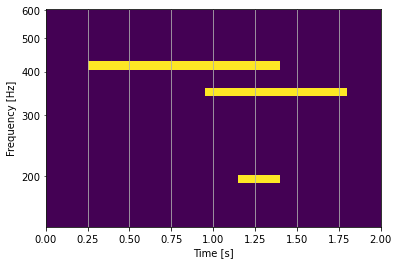

event_seq: 12 [('TIME_SHIFT', 250), ('NOTE_ON', 68), ('TIME_SHIFT', 700), ('NOTE_ON', 65), ('TIME_SHIFT', 200), ('NOTE_ON', 55), ('TIME_SHIFT', 250), ('NOTE_OFF', 55), ('NOTE_OFF', 68), ('TIME_SHIFT', 400), ('NOTE_OFF', 65), ('TIME_SHIFT', 200)]


In [5]:
duration_ms = 2000
timecell_ms = 50
Fs = 48000
tp_matrix = random_tp_matrix(duration_ms, timecell_ms)
print('tp_matrix:', tp_matrix.shape)
visualize_tp_matrix(tp_matrix, Fs, timecell_ms)
event_seq = tp_matrix_to_event_seq(tp_matrix, timecell_ms)
print('event_seq:', len(event_seq), event_seq)

fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.


samples: (192000,) int16 -2441 2384 -0.606328125
x: (96000,) float64 -0.28631591796875 0.26898193359375 -7.401466369628906e-05 0.04344887353270451


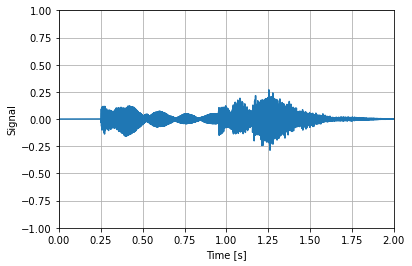

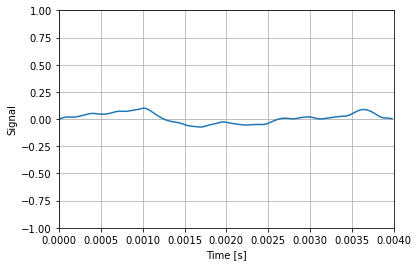

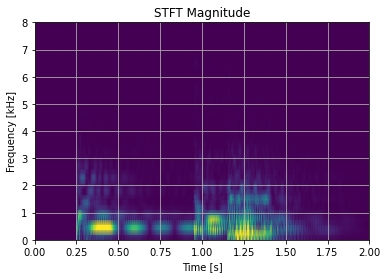

In [12]:
soundfont_fp = "../soundfonts/mia_piano.sf2"
amplify = 4.0  # Some soundfonts are more quiet than others.

samples = event_seq_to_waveform(soundfont_fp, event_seq, Fs)
print('samples:', samples.shape, samples.dtype, samples.min(), samples.max(), samples.mean())
# NOTE: np.stack([samples[::2], samples[1::2]]) would result in binaural audio (two channels).
x = (samples[::2] + samples[1::2]) / 2.0  # Stereo to mono.
x = x * amplify / 32768.0  # Normalize.
print('x:', x.shape, x.dtype, x.min(), x.max(), x.mean(), x.std())
plot_waveform(x, Fs, zoom=1)
plot_waveform(x, Fs, zoom=500)
plot_stft(x, Fs)
play(x, Fs)

## Can you retain sound quality from just STFT magnitude? (answer: no)

Just ignore this.

f: (257,)  t: (376,)  Zxx: (257, 376)
f: [  0.    93.75 187.5  281.25]
t: [0.         0.00533333 0.01066667 0.016     ]
Zxx: [[-9.97692647e-08+0.00000000e+00j -3.11904805e-07+0.00000000e+00j]
 [ 2.24244159e-07+1.06102234e-07j  3.21545239e-07-1.43453707e-07j]]


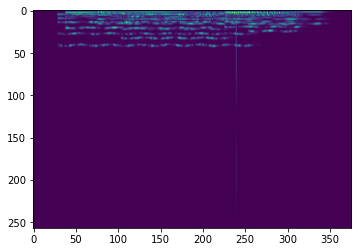

In [10]:
f, t, Zxx = scipy.signal.stft(x, Fs, nperseg=512)
print('f:', f.shape, ' t:', t.shape, ' Zxx:', Zxx.shape)
print('f:', f[:4])
print('t:', t[:4])
print('Zxx:', Zxx[:2, :2])
plt.imshow(np.abs(Zxx))
plt.show()

t: (96000,)  xr: (96000,)
t: [0. 1. 2. 3.]
xr: [ 2.85697141e-07  3.84085431e-07 -1.02775738e-06  9.28690376e-07]


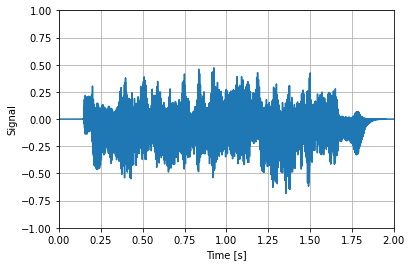

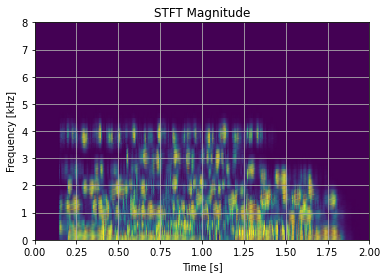

In [12]:
used = np.abs(Zxx)
t, xr = scipy.signal.istft(used, nperseg=512)
xr *= 3.0
print('t:', t.shape, ' xr:', xr.shape)
print('t:', t[:4])
print('xr:', xr[:4])
plot_waveform(xr, Fs, zoom=1)
plot_stft(xr, Fs)
play(xr, Fs)

f: (257,)  t: (376,)  Zxx: (257, 376)
f: [  0.    93.75 187.5  281.25]
t: [0.         0.00533333 0.01066667 0.016     ]
Zxx: [[-1.33634931e-07+0.00000000e+00j  5.27317042e-08+0.00000000e+00j]
 [ 3.27581897e-08-1.16949632e-07j -1.04049189e-08+2.45403887e-07j]]


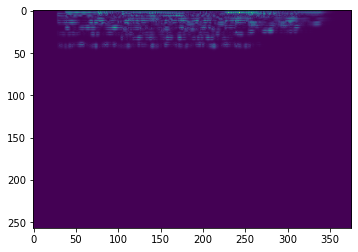

relative error between |Zxx| and |Zxxr|: 0.8307834889894689


In [21]:
f, t, Zxxr = scipy.signal.stft(xr, Fs, nperseg=512)
print('f:', f.shape, ' t:', t.shape, ' Zxx:', Zxx.shape)
print('f:', f[:4])
print('t:', t[:4])
print('Zxx:', Zxxr[:2, :2])
plt.imshow(np.abs(Zxxr))
plt.show()
print('relative error between |Zxx| and |Zxxr|:', np.abs(np.abs(Zxx) - np.abs(Zxxr)).sum() / np.abs(Zxx).sum())

In [6]:
# import librosa
# x2 = librosa.griffinlim(np.abs(Zxx))
# print('x2:', x2.shape)
# print('t:', t[:4])
# print('x2:', x2[:4])
# plot_waveform(x2, Fs, zoom=1)
# plot_stft(x2, Fs)
# play(x2, Fs)